/home/grtsinry43/.conda/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 数据集概览 ---
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0       

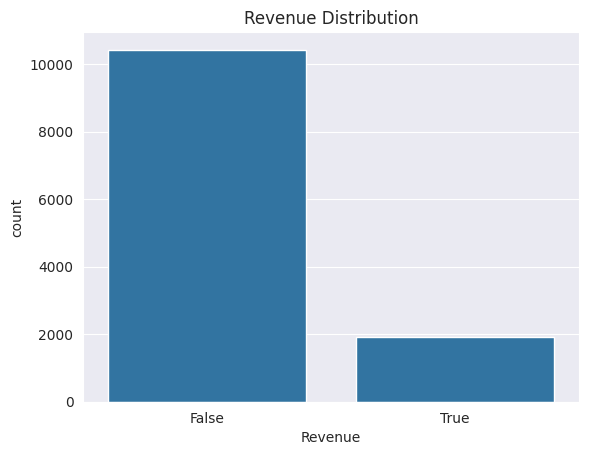

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

try:
    df = pd.read_csv("hf://datasets/schooly/online-shoppers-intention/online_shoppers_intention.csv")
except FileNotFoundError:
    print(f"错误: 数据集联网加载失败")
    exit()

# --- 初步数据探索 ---
print("--- 数据集概览 ---")
print(df.head())
print("\n--- 数据信息 ---")
df.info()
print("\n--- 描述性统计 ---")
print(df.describe())
print("\n--- 缺失值检查 ---")
print(df.isnull().sum())

# 目标变量分布
print("\n--- 目标变量 'Revenue' 分布 ---")
print(df['Revenue'].value_counts(normalize=True))
sns.countplot(x='Revenue', data=df)
plt.title('Revenue Distribution')
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- 数据预处理 ---
# 将布尔值转换为整数
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)  # 目标变量

# 识别类别特征和数值特征
categorical_features = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
# 'OperatingSystems', 'Browser', 'Region', 'TrafficType' 是数值类型，但它们代表类别，所以也当类别处理
# 确保将这些数值型类别特征转换为字符串类型，以便OneHotEncoder正确处理
for col in ['OperatingSystems', 'Browser', 'Region', 'TrafficType']:
    df[col] = df[col].astype(str)

numerical_features = ['Administrative', 'Administrative_Duration', 'Informational',
                      'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                      'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# 创建预处理器
# 对于数值特征：进行标准化
# 对于类别特征：进行独热编码 (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # 保留其他未指定列 (如 'Weekend', 'Revenue')
)

# 分离特征和目标变量
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# 应用预处理
# 注意：ColumnTransformer 会改变列的顺序和数量
X_processed = preprocessor.fit_transform(X)

# 如果 X_processed 是稀疏矩阵，转换为密集数组
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

print(f"\n--- 处理后的特征维度 ---")
print(X_processed.shape)

# 划分训练集和测试集
# 这里的 random_state 是为了结果可复现
X_train, X_test, y_train, y_test = train_test_split(X_processed, y.values, test_size=0.2, random_state=42, stratify=y)

print(f"训练集大小: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试集大小: X_test: {X_test.shape}, y_test: {y_test.shape}")


--- 处理后的特征维度 ---
(12330, 74)
训练集大小: X_train: (9864, 74), y_train: (9864,)
测试集大小: X_test: (2466, 74), y_test: (2466,)


In [ ]:
# --- 从零实现逻辑回归 ---
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.verbose = verbose  # 是否打印训练过程中的损失
        self.costs = []  # 记录每次迭代的损失

    def _sigmoid(self, z):
        # 防止溢出
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # 初始化权重和偏置
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.costs = []

        # 梯度下降
        for i in range(self.n_iterations):
            # 线性模型: z = X.w + b
            linear_model = np.dot(X, self.weights) + self.bias
            # 应用sigmoid函数得到预测概率
            y_predicted_proba = self._sigmoid(linear_model)

            # 计算梯度
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted_proba - y))
            db = (1 / n_samples) * np.sum(y_predicted_proba - y)

            # 更新权重和偏置
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # 计算并记录损失 (Binary Cross-Entropy)
            # 添加一个小的epsilon防止log(0)
            epsilon = 1e-9
            cost = - (1 / n_samples) * np.sum(
                y * np.log(y_predicted_proba + epsilon) + (1 - y) * np.log(1 - y_predicted_proba + epsilon))
            self.costs.append(cost)

            if self.verbose and (i % (self.n_iterations // 10) == 0 or i == self.n_iterations - 1):
                print(f"Iteration {i}, Cost: {cost:.4f}")

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_predicted_proba = self.predict_proba(X)
        y_predicted_labels = [1 if i > threshold else 0 for i in y_predicted_proba]
        return np.array(y_predicted_labels)

In [ ]:
# --- 训练自定义逻辑回归模型 ---
print("\n--- 训练自定义逻辑回归模型 ---")
log_reg_model = MyLogisticRegression(learning_rate=0.1, n_iterations=2000, verbose=True)  # 调整参数
log_reg_model.fit(X_train, y_train)

# 绘制损失曲线
plt.figure()
plt.plot(range(len(log_reg_model.costs)), log_reg_model.costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Logistic Regression Training Cost")
plt.show()

# --- 进行预测 ---
y_pred_proba = log_reg_model.predict_proba(X_test)  # 获取概率用于ROC曲线
y_pred_labels = log_reg_model.predict(X_test)  # 获取类别标签

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report

print("\n--- 模型评估 ---")
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels, target_names=['Will Not Buy (0)', 'Will Buy (1)']))

print("\n混淆矩阵:")
cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

In [ ]:
import numpy as np
from tqdm import tqdm
import time


def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)


def rbf_kernel(X1, X2, gamma=0.1):
    if X1.ndim == 1:
        X1 = X1[np.newaxis, :]
    if X2.ndim == 1:
        X2 = X2[np.newaxis, :]
    sq_dists = np.sum(X1 ** 2, axis=1)[:, None] + np.sum(X2 ** 2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)


class SMO_SVM:
    def __init__(self, C=1.0, kernel='rbf', gamma=0.1, tol=1e-3, max_passes=5):
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = rbf_kernel if kernel == 'rbf' else linear_kernel
        self.alphas = None
        self.b = 0
        self.X = None
        self.y = None

    def fit(self, X, y):
        y = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape
        self.X = X
        self.y = y
        self.alphas = np.zeros(n_samples)
        self.b = 0
        passes = 0
        K = self.kernel(X, X) if self.kernel != rbf_kernel else rbf_kernel(X, X, self.gamma)

        with tqdm(total=self.max_passes, desc="SVM Training Progress") as pbar:
            while passes < self.max_passes:
                alpha_changed = 0
                print(f"\nPass {passes + 1}/{self.max_passes}")
                start_time = time.time()
                for i in range(n_samples):
                    Ei = self._E(i, K)
                    if (y[i] * Ei < -self.tol and self.alphas[i] < self.C) or (
                            y[i] * Ei > self.tol and self.alphas[i] > 0):
                        j = np.random.choice([x for x in range(n_samples) if x != i])
                        Ej = self._E(j, K)

                        alpha_i_old = self.alphas[i].copy()
                        alpha_j_old = self.alphas[j].copy()

                        if y[i] != y[j]:
                            L = max(0, self.alphas[j] - self.alphas[i])
                            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                        else:
                            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                            H = min(self.C, self.alphas[i] + self.alphas[j])
                        if L == H:
                            continue

                        eta = 2 * K[i, j] - K[i, i] - K[j, j]
                        if eta >= 0:
                            continue

                        self.alphas[j] -= y[j] * (Ei - Ej) / eta
                        self.alphas[j] = np.clip(self.alphas[j], L, H)

                        if abs(self.alphas[j] - alpha_j_old) < 1e-5:
                            continue

                        self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                        b1 = self.b - Ei - y[i] * (self.alphas[i] - alpha_i_old) * K[i, i] - y[j] * (
                                self.alphas[j] - alpha_j_old) * K[i, j]
                        b2 = self.b - Ej - y[i] * (self.alphas[i] - alpha_i_old) * K[i, j] - y[j] * (
                                self.alphas[j] - alpha_j_old) * K[j, j]

                        if 0 < self.alphas[i] < self.C:
                            self.b = b1
                        elif 0 < self.alphas[j] < self.C:
                            self.b = b2
                        else:
                            self.b = (b1 + b2) / 2

                        alpha_changed += 1

                    # # Add detailed log for each sample
                    # if i % 100 == 0 or i == n_samples - 1:
                    #     print(f"  Sample {i + 1}/{n_samples}, alpha_changed: {alpha_changed}")

                print(
                    f"Pass {passes + 1} finished, alpha_changed: {alpha_changed}, time: {time.time() - start_time:.2f}s")
                if alpha_changed == 0:
                    passes += 1
                    pbar.update(1)
                else:
                    passes = 0

    def _E(self, i, K):
        return self._f(i, K) - self.y[i]

    def _f(self, i, K):
        return np.sum(self.alphas * self.y * K[:, i]) + self.b

    def project(self, X):
        K = self.kernel(self.X, X) if self.kernel != rbf_kernel else rbf_kernel(self.X, X, self.gamma)
        return (self.alphas * self.y) @ K + self.b

    def predict(self, X):
        return np.where(self.project(X) >= 0, 1, 0)

In [ ]:
# --- 训练自定义线性SVM模型 ---
print("\n--- 训练自定义线性SVM模型 ---")
svm_model = SMO_SVM(C=1.0, kernel='rbf', tol=1e-3, max_passes=5)
svm_model.fit(X_train, y_train)
y_pred_labels_svm = svm_model.predict(X_test)
print("\n--- SVM模型评估 ---")
accuracy_svm = accuracy_score(y_test, y_pred_labels_svm)
print(f"Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_svm, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_svm = confusion_matrix(y_test, y_pred_labels_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()
# ROC曲线和AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.project(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_svm:.4f}")

In [ ]:
import numpy as np
from collections import Counter


class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion  # 'gini' or 'entropy'
        self.tree = None

    def _calculate_impurity(self, y):
        # 计算y中各类别比例
        class_counts = Counter(y)
        total_samples = len(y)
        impurity = 0
        if total_samples == 0:
            return 0

        if self.criterion == 'gini':
            for cls_count in class_counts.values():
                p_k = cls_count / total_samples
                impurity += p_k * (1 - p_k)  # Gini = sum(pk * (1-pk)) or 1 - sum(pk^2)
            # return 1 - impurity # if using 1 - sum(pk^2)
            return impurity
        elif self.criterion == 'entropy':
            for cls_count in class_counts.values():
                p_k = cls_count / total_samples
                if p_k > 0:  # log2(0) is undefined
                    impurity -= p_k * np.log2(p_k)
            return impurity
        else:
            raise ValueError("Unknown criterion.")

    def _calculate_information_gain(self, X_column, y, threshold):
        parent_impurity = self._calculate_impurity(y)

        # 根据阈值划分数据
        left_indices = X_column <= threshold
        right_indices = X_column > threshold

        y_left, y_right = y[left_indices], y[right_indices]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0  # 如果划分导致一个子集为空，则增益为0

        n = len(y)
        n_left, n_right = len(y_left), len(y_right)

        impurity_left = self._calculate_impurity(y_left)
        impurity_right = self._calculate_impurity(y_right)

        child_impurity = (n_left / n) * impurity_left + (n_right / n) * impurity_right
        information_gain = parent_impurity - child_impurity
        return information_gain

    def _find_best_split(self, X, y):
        best_gain = -1
        best_feature_idx = None
        best_threshold = None
        n_features = X.shape[1]

        for feature_idx in range(n_features):
            X_column = X[:, feature_idx]
            # 对于数值特征，可能的阈值是排序后唯一值的中间点
            # 简化的做法: 尝试每个唯一值作为阈值 (或它们之间的中点)
            thresholds = np.unique(X_column)
            if len(thresholds) > 10:  # 抽样一部分阈值避免计算量过大
                thresholds = np.percentile(X_column, np.arange(10, 100, 10))

            for threshold in thresholds:
                gain = self._calculate_information_gain(X_column, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # 停止条件
        if (self.max_depth is not None and depth >= self.max_depth) or \
                n_labels == 1 or \
                n_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]  # 叶节点值为多数类
            return {'value': leaf_value}  # 使用字典表示叶节点

        best_feature_idx, best_threshold, best_gain = self._find_best_split(X, y)

        # 如果信息增益很小，也停止分裂 (避免过拟合)
        if best_gain <= 0.001:  # 可调参数
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'value': leaf_value}

        # 划分数据集
        left_indices = X[:, best_feature_idx] <= best_threshold
        right_indices = X[:, best_feature_idx] > best_threshold

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # 确保子集非空，如果一个子集为空，则无法继续分裂，当前节点成为叶节点
        if len(y_left) == 0 or len(y_right) == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'value': leaf_value}

        # 递归构建左右子树
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return {
            'feature_index': best_feature_idx,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'info_gain': best_gain  # 可选
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        if 'value' in node:  # 是叶节点
            return node['value']

        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

In [ ]:
# --- 训练自定义决策树模型 ---
print("\n--- 训练自定义决策树模型 ---")
tree_model = MyDecisionTreeClassifier(max_depth=5, min_samples_split=2, criterion='gini')
tree_model.fit(X_train, y_train)
y_pred_labels_tree = tree_model.predict(X_test)
print("\n--- 决策树模型评估 ---")
accuracy_tree = accuracy_score(y_test, y_pred_labels_tree)
print(f"Accuracy: {accuracy_tree:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_tree, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_tree = confusion_matrix(y_test, y_pred_labels_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()
# ROC曲线和AUC
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_labels_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_tree:.4f}")

In [ ]:
import numpy as np


class MyGaussianNaiveBayes:
    def __init__(self):
        self.class_priors_ = None
        self.class_means_ = None
        self.class_vars_ = None  # 或者 stds_
        self.classes_ = None
        self.epsilon = 1e-9  # 防止除以零或log(0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_priors_ = np.zeros(n_classes)
        self.class_means_ = np.zeros((n_classes, n_features))
        self.class_vars_ = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]  # 取出类别c的所有样本
            self.class_priors_[idx] = X_c.shape[0] / n_samples
            self.class_means_[idx, :] = X_c.mean(axis=0)
            self.class_vars_[idx, :] = X_c.var(axis=0) + self.epsilon  # 添加epsilon防止方差为0

    def _pdf(self, class_idx, x_row):  # x_row是单个样本的特征向量
        mean = self.class_means_[class_idx]
        var = self.class_vars_[class_idx]
        # log_pdf = -0.5 * np.sum(np.log(2. * np.pi * var)) - 0.5 * np.sum(((x_row - mean) ** 2) / var)
        # 直接计算概率，但要注意下溢风险，通常用log-sum-exp技巧
        numerator = np.exp(-((x_row - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator  # 这会返回每个特征的P(xj|yk)

    def _calculate_log_class_probability(self, class_idx, x_row):
        log_prior = np.log(self.class_priors_[class_idx] + self.epsilon)

        mean = self.class_means_[class_idx]
        var = self.class_vars_[class_idx]  # var = std^2

        # log( P(xj | yk) ) = -log(sqrt(2*pi*var_j)) - (xj - mean_j)^2 / (2*var_j)
        log_likelihood_terms = -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x_row - mean) ** 2) / var
        log_likelihood = np.sum(log_likelihood_terms)

        return log_prior + log_likelihood

    def predict_proba(self, X):  # 返回每个类别的对数后验概率（未归一化）或归一化概率
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        log_posteriors = np.zeros((n_samples, n_classes))

        for i in range(n_samples):
            for class_idx in range(n_classes):
                log_posteriors[i, class_idx] = self._calculate_log_class_probability(class_idx, X[i])

        # 归一化得到概率 (可选，如果只需要类别可以省略)
        # log_sum_exp 技巧避免下溢/上溢
        max_log = np.max(log_posteriors, axis=1, keepdims=True)
        log_posteriors_shifted = log_posteriors - max_log
        exp_log_posteriors_shifted = np.exp(log_posteriors_shifted)
        sum_exp = np.sum(exp_log_posteriors_shifted, axis=1, keepdims=True)
        probabilities = exp_log_posteriors_shifted / sum_exp
        return probabilities

    def predict(self, X):
        predictions = []
        for x_row in X:
            posteriors = []
            for class_idx, c in enumerate(self.classes_):
                log_posterior = self._calculate_log_class_probability(class_idx, x_row)
                posteriors.append(log_posterior)
            predictions.append(self.classes_[np.argmax(posteriors)])
        return np.array(predictions)

In [ ]:
# --- 训练自定义朴素贝叶斯模型 ---
print("\n--- 训练自定义朴素贝叶斯模型 ---")
nb_model = MyGaussianNaiveBayes()
nb_model.fit(X_train, y_train)
y_pred_labels_nb = nb_model.predict(X_test)
print("\n--- 朴素贝叶斯模型评估 ---")
accuracy_nb = accuracy_score(y_test, y_pred_labels_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_nb, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_nb = confusion_matrix(y_test, y_pred_labels_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()
# ROC曲线和AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_labels_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_nb:.4f}")

In [ ]:
import numpy as np
from collections import Counter


class MyKNearestNeighbors:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _predict_single(self, x_test_sample):
        distances = [self._euclidean_distance(x_test_sample, x_train_sample) for x_train_sample in self.X_train]
        # 获取k个最近邻的索引
        k_indices = np.argsort(distances)[:self.k]
        # 获取k个最近邻的标签
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # 多数投票
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X_test):
        predictions = [self._predict_single(x_test_sample) for x_test_sample in X_test]
        return np.array(predictions)

In [ ]:
# --- 训练自定义KNN模型 ---
print("\n--- 训练自定义KNN模型 ---")
knn_model = MyKNearestNeighbors(k=5)  # k值可以调整
knn_model.fit(X_train, y_train)
y_pred_labels_knn = knn_model.predict(X_test)
print("\n--- KNN模型评估 ---")
accuracy_knn = accuracy_score(y_test, y_pred_labels_knn)
print(f"Accuracy: {accuracy_knn:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_knn, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_knn = confusion_matrix(y_test, y_pred_labels_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()
# ROC曲线和AUC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_labels_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_knn:.4f}")
